# Convolutional Variational Autoencoder
mnist의 손글씨 데이터를 생성하는 방법
pip install imageio

# Import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
        pass
import tensorflow as tf
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [4]:
tf.enable_eager_execution()

# DATA
- 각 mnist images는 784정수 벡터이고 0~255로 픽셀을 나타냄.
- 각 픽셀을 Bernoulli dist.으로 모델을 만들거야

In [5]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [6]:
# reshape data
train_images = np.expand_dims(train_images, -1).astype('float32')
test_images = np.expand_dims(test_images, -1).astype('float32')
# Normalization data to the range of [0., 1.]
train_images /= 255.
test_images /= 255.
# check
print(train_images.shape, test_images.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [7]:
# Binarization : 위에서 [0,1]로 normalize했기에 절반보다 크면 1 작으면 0으로 이분화
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0. 
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0. 


# Data pipline

In [8]:
train_buf = 60000
test_buf = 10000
batch_size = 100


train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_buf).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_buf).batch(batch_size)

# Inference Network(encoding)
This defines an approximate posterior distribution q(z|x), which takes as input an observation (x) and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution q(z|x) as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

# Generative Network(decoding)
This defines the generative model which takes a latent encoding (z) as input, and outputs the parameters for a conditional distribution of the observation, i.e.p(x|z). Additionally, we use a unit Gaussian prior p(z) for the latent variable.

# Reparameterization Trick
During optimization, we can sample from q(z|x) by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

# Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [76]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Model Architecture
        
        # Encoder - 2*Conv + Dense
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = (28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters= 32, kernel_size = 3, strides=(2,2),activation = 'relu'),
                tf.keras.layers.Conv2D(
                    filters= 64, kernel_size = 3, strides=(2,2),activation = 'relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        
        
        # Decoder - Dense + 2*Conv2DT + 1Conv2DT
        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
                
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7,7,32)),

                tf.keras.layers.Conv2DTranspose(
                filters=64,
                kernel_size = 3,
                strides=(2,2),
                padding = 'SAME',
                activation='relu'),

                tf.keras.layers.Conv2DTranspose(
                filters=32,
                kernel_size = 3,
                strides=(2,2),
                padding = 'SAME',
                activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x),num_or_size_splits=2, axis=1)
        #Splits a tensor into sub tensors. -> inference_net을 통해 나온 값을 mean과 logvar로 나누기
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape = mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid = False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

# Define the loss function and the optimizer
In practice, we optimize the single sample Monte Carlo estimate of this expectation:
logp(x|z)+logp(z)-logq(z|x),
where z is sampled from q(z|x).

Note: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [77]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis = 1):
    log2pi = tf.math.log(2.*np.pi)
    return tf.reduce_sum(
    -.5*((sample-mean)**2.*tf.exp(-logvar)+logvar+log2pi),
    axis = raxis)

@tf.function
def compute_loss(model, x):
    mean,logvar = model.encode(x)
    z = model.reparameterize(mean,logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits = x_logit,labels = x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z,0.,0.)
    logqz_x = log_normal_pdf(z,mean,logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_appy_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars = zip(gradients, model.trainable_variables))

## training
- We start by iterating over the dataset
- During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior q(z|x)
- We then apply the reparameterization trick to sample from q(z|x)
- Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution p(x|z)
- Note: Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST

## Generate Images
- After training, it is time to generate some images
- We start by sampling a set of latent vectors from the unit Gaussian prior distribution p(z)
- The generator will then convert the latent sample (z) to logits of the observation, giving a distribution p(x|z)
- Here we plot the probabilities of Bernoulli distributions

In [78]:
epochs = 30
latent_dim = 50
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(
    shape = [num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)


In [79]:
def generate_and_save_images(model,epoch,test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0],cmap='gray')
        plt.axis('off')
        
    # tight_layout minimizes the overlap between 2 sub-plots    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 3, Test set ELBO: -121.8753890991211,time elapse for current epoch 34.89178109169006


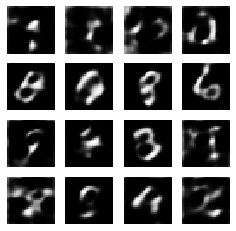

In [ ]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs+1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_appy_gradients(model,train_x,optimizer)
    end_time = time.time()
    
    if epoch % 1 ==0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {},'
             'time elapse for current epoch {}'.format(epoch,elbo,end_time-start_time))
        
        generate_and_save_images(
            model, epoch, random_vector_for_generation)